# AdalFlow on FIQA Data & Optimize Answer Generation

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import re
import dspy
import contextlib
from pprint import pprint
from datasets import load_dataset
from dataclasses import dataclass, field
from typing import Union, Dict, Callable, Any, Tuple

import adalflow as adal
from adalflow.datasets.hotpot_qa import HotPotQAData
from adalflow.components.model_client.openai_client import OpenAIClient
from adalflow.eval.g_eval import GEvalLLMJudge, GEvalJudgeEvaluator, NLGTask

import warnings
warnings.filterwarnings('ignore')


model_str = "gpt-4.1-nano"
gpt4_model = {
    "model_client": OpenAIClient(),
    "model_kwargs": {
        "model": model_str,
        "temperature": 0.7,
    },
}
model_kwargs = {
        "model": model_str,
        "temperature": 0.7,
    }

### Create Data Input

* Load fiqa data and convert to AdalFlow's HotPotQAData format
  * So far, this is the only data format I knew AdaalFlow can process...😅
* About the Data Source: https://huggingface.co/datasets/explodinggradients/fiqa
  * Only 30 records

In [2]:
fiqa_eval = load_dataset("explodinggradients/fiqa", "ragas_eval")['baseline']

rag_lst = []
for record in fiqa_eval:
    rag_lst.append({
        'question': record['question'],
        'context': record['contexts'],
        'ground_truth': record['ground_truths'][0],
        'answer_before_prompt_opt': record['answer'].strip()
    })

rag_df = pd.DataFrame(rag_lst)
print(rag_df.shape)
rag_df.head()

(30, 4)


,question,context,ground_truth,answer_before_prompt_opt
0,How to deposit a cheque issued to an associate...,[Just have the associate sign the back and the...,Have the check reissued to the proper payee.Ju...,The best way to deposit a cheque issued to an ...
1,Can I send a money order from USPS as a business?,[Sure you can. You can fill in whatever you w...,Sure you can. You can fill in whatever you wa...,"Yes, you can send a money order from USPS as a..."
2,1 EIN doing business under multiple business n...,[You're confusing a lot of things here. Compan...,You're confusing a lot of things here. Company...,"Yes, it is possible to have one EIN doing busi..."
3,Applying for and receiving business credit,[Set up a meeting with the bank that handles y...,"""I'm afraid the great myth of limited liabilit...",Applying for and receiving business credit can...
4,401k Transfer After Business Closure,[The time horizon for your 401K/IRA is essenti...,You should probably consult an attorney. Howev...,If your employer has closed and you need to tr...


In [3]:
def fiqa_to_hotpotqa(record):
    return HotPotQAData(
        question=record['question'],
        gold_titles=record['ground_truths'][0],
        context=record['contexts'],
        answer=record['answer'].strip(),  # answer_before_prompt_opt
    )

fiqa_as_hotpotqa = [fiqa_to_hotpotqa(s) for s in fiqa_eval]
print(len(fiqa_as_hotpotqa))
fiqa_as_hotpotqa[0].to_dict()

30


{'question': 'How to deposit a cheque issued to an associate in my business into my business account?',
 'answer': 'The best way to deposit a cheque issued to an associate in your business into your business account is to open a business account with the bank. You will need a state-issued "dba" certificate from the county clerk\'s office as well as an Employer ID Number (EIN) issued by the IRS. Once you have opened the business account, you can have the associate sign the back of the cheque and deposit it into the business account.',
 'id': 'b7f0d34e-d36a-491e-a6b6-f276f8e4a9e1',
 'gold_titles': "Have the check reissued to the proper payee.Just have the associate sign the back and then deposit it.  It's called a third party cheque and is perfectly legal.  I wouldn't be surprised if it has a longer hold period and, as always, you don't get the money if the cheque doesn't clear. Now, you may have problems if it's a large amount or you're not very well known at the bank.  In that case you

### AdalFlow Optimization

* References
  * How to use AdalFlow's GEval and LLM-as-Judge: https://colab.research.google.com/github/SylphAI-Inc/AdalFlow/blob/main/notebooks/evaluation/adalflow_llm_eval.ipynb
  * Official evaluation page (I think their user guide is very confusing 😅): https://adalflow.sylph.ai/apis/eval/index.html

In [4]:
task_desc_str = r"""Answer questions with short factoid answers.
                    You will receive context(contain relevant facts).
                    Think step by step.
                """


answer_template = """<START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
    Here are some examples:
    {{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
    Context: {{context}}
    Question: {{question}}
<END_OF_USER>
"""


trainset = fiqa_as_hotpotqa[0:10]
valset = fiqa_as_hotpotqa[10:20]
testset = fiqa_as_hotpotqa[20:]

In [5]:
@dataclass
class AnswerData(adal.DataClass):
    reasoning: str = field(
        metadata={"desc": "The reasoning to produce the answer"},
    )
    answer: str = field(
        metadata={"desc": "The answer you produced"},
    )

    __output_fields__ = ["reasoning", "answer"]


class RAG_AnswerGeneration(adal.Component):
    def __init__(self, model_client=None, model_kwargs=None):
        super().__init__()

        self.llm_parser = adal.DataClassParser(
            data_class=AnswerData, return_data_class=True, format_type="json"
        )
        self.llm = adal.Generator(
            model_client=model_client,
            model_kwargs=model_kwargs,
            prompt_kwargs={
                "task_desc_str": adal.Parameter(
                    data=task_desc_str,
                    role_desc="""Task description for the language model,\
                            used with the following template: \
                                {{task_desc_str}} \
                                {{output_format_str}}\
                            <START_OF_USER>
                                Context: {{context}}
                                Question: {{question}}
                            <END_OF_USER>""",
                    param_type=adal.ParameterType.PROMPT,
                    requires_opt=True,
                    instruction_to_backward_engine="""You need find the best way
                            (where does the right answer come from the context) 
                            to extract the RIGHT answer from the context.""",
                    instruction_to_optimizer="""You need find the best way
                            (where does the right answer come from the context)
                            to extract the RIGHT answer from the context.""",
                ),
                "output_format_str": self.llm_parser.get_output_format_str(),
            },
            template=answer_template,
            output_processors=self.llm_parser,
            use_cache=True,
        )

    def bicall(
        self, 
        question: str, 
        retrieved_context: str,
        id: str = None
    ) -> Union[adal.GeneratorOutput, adal.Parameter]:
        """
            This function is used to call the model for both training and eval mode.
        """
        prompt_kwargs = {
            "context": retrieved_context,
            "question": question,
        }
        output = self.llm(prompt_kwargs=prompt_kwargs, id=id)
        return output

In [6]:
# test above RAG_AnswerGeneration logic
random_test_data = fiqa_as_hotpotqa[0].to_dict()

rag = RAG_AnswerGeneration(**gpt4_model)
output = rag.bicall(
    question=random_test_data['question'],
    retrieved_context=random_test_data['context'],
)
print(output)
pprint(output.data)

GeneratorOutput(id=None, data=AnswerData(reasoning="The context explains that for a business to deposit a cheque issued to an associate into their business account, the associate should endorse the cheque on the back and deposit it, preferably in front of a teller with ID if the amount is large or the bank is unfamiliar. Additionally, having a business account in the company's name simplifies the process, as personal or third-party cheques should ideally be made out to the business to avoid complications.", answer='Have the associate endorse the back of the cheque and deposit it into your business account, preferably in front of a teller with ID if necessary.'), error=None, usage=CompletionUsage(completion_tokens=130, prompt_tokens=736, total_tokens=866), raw_response='```json\n{\n    "reasoning": "The context explains that for a business to deposit a cheque issued to an associate into their business account, the associate should endorse the cheque on the back and deposit it, preferabl

In [7]:
class HotPotQAAdal(adal.AdalComponent):
    def __init__(
        self,
        backward_engine_model_config: Dict | None = None,
        teacher_model_config: Dict | None = None,
        text_optimizer_model_config: Dict | None = None,
        task: adal.Component | None = None,  # initialized task
    ):
        g_eval = GEvalLLMJudge(default_task=NLGTask.SUMMARIZATION,
                                model_kwargs=model_kwargs)
        g_evaluator = GEvalJudgeEvaluator(llm_judge=g_eval)
        def extract_overall(**kwargs):
            if 'input_str'  in kwargs:
                match = re.search(r"Reference Answer:(.*)Predicted Answer:(.*)", kwargs['input_str'], re.DOTALL)
                if match:
                    reference = match.group(1).strip()
                    predicted = match.group(2).strip()
            else:
                predicted = kwargs.get("y")
                reference = kwargs.get("y_gt")

            input_str = f"Reference Answer: {reference}\nPredicted Answer: {predicted}"
            return g_evaluator.compute_single_item(input_str)["overall"]

        eval_fn = extract_overall
        loss_eval_fn = extract_overall

        loss_fn = adal.EvalFnToTextLoss(
            eval_fn=loss_eval_fn,
            eval_fn_desc="GEval score",
        )
        super().__init__(
            task=task,
            eval_fn=eval_fn,
            loss_eval_fn=loss_eval_fn,
            loss_fn=loss_fn,
            backward_engine_model_config=backward_engine_model_config,
            teacher_model_config=teacher_model_config,
            text_optimizer_model_config=text_optimizer_model_config,
        )

    def prepare_task(self, sample: HotPotQAData) -> Tuple[Callable[..., Any], Dict]:
        if self.task.training:
            return self.task.forward, {"question": sample.question,
                                       "retrieved_context": sample.context,
                                        "id": sample.id}
        else:
            return self.task.call, {"question": sample.question,
                                    "retrieved_context": sample.context,
                                     "id": sample.id}

    def prepare_eval(self, sample: HotPotQAData, y_pred: adal.GeneratorOutput):
        y_label = ""
        if y_pred and y_pred.data and y_pred.data.answer:
            y_label = y_pred.data.answer

        input_str = (
            f"Reference Answer: {sample.gold_titles}\n"
            f"Predicted Answer: {y_label}"
        )

        return self.eval_fn, {'input_str': input_str}


    def prepare_loss_eval(self, sample: Any, y_pred: Any, *args, **kwargs):
        y_label = ""
        if y_pred and y_pred.data and y_pred.data.answer:
            y_label = y_pred.data.answer

        input_str = (
            f"Reference Answer: {sample.gold_titles}\n"
            f"Predicted Answer: {y_label}"
        )

        return self.loss_eval_fn, {'input_str': input_str}


    def prepare_loss(self, sample: HotPotQAData, pred: adal.Parameter):
        y_gt = adal.Parameter(
            name="y_gt",
            data=sample.gold_titles,
            eval_input=sample.gold_titles,
            requires_opt=False,
        )
        context_param = adal.Parameter(
            name="context",
            data=sample.context,
            eval_input=sample.context,  # you could also stringify it if needed
            requires_opt=False,
        )

        pred.eval_input = (
            pred.data.data.answer
            if pred.data and pred.data.data and pred.data.data.answer
            else ""
        )
        return self.loss_fn, {
            "kwargs": {"y": pred, "y_gt": y_gt,
                        "context": context_param},
            "input": {"question": sample.question,
                       "retrieved_context": sample.context},
            "gt": sample.gold_titles,
            "id": sample.id,
        }

<b>Evaluation Only</b>

In [8]:
def train_diagnose(model_client, model_kwargs):
    task = RAG_AnswerGeneration(
        model_client=model_client,
        model_kwargs=model_kwargs
    )

    adal_component = HotPotQAAdal(
        task=task,
    )
    trainer = adal.Trainer(adaltask=adal_component)
    trainer.diagnose(dataset=testset, split="train")


train_diagnose(**gpt4_model)

Generator llm is already registered with jsonl file at C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\VallinaRAGAdal\diagnose_train\llm_call.jsonl


2025-06-29 22:08:37 - [trainer.py:227:diagnose] - Checkpoint path: C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal


Loading Data: 100%|██████████| 10/10 [00:00<00:00, 2164.13it/s]
Predicting: step(0): 0.6167 across 10 samples, Max potential: 0.6167: 100%|██████████| 10/10 [00:00<00:00, 135.89it/s]
Error loading jsonl file C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\VallinaRAGAdal\diagnose_train\llm_call.jsonl: line contains invalid json: Trailing data (line 46)


Log file C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\VallinaRAGAdal\diagnose_train\llm_call.jsonl is empty. This llm is not called at all.

================== DIAGNOSE REPORT ==================

✔ Split: train
✔ Overall accuracy score: 0.62
✔ Log paths:
  - Log 1: C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\VallinaRAGAdal\diagnose_train\llm_call.jsonl

✔ Diagnose report completed successfully!




<b>Training</b>

In [9]:
def train(
    task_model_cliet,
    task_model_kwargs,
    optimizer_model_config,
    backward_engine_model_config,
    train_batch_size=4,  # larger batch size is not that effective, probably because of llm's lost in the middle
    raw_shots: int = 0,
    bootstrap_shots: int = 4,
    max_steps=1,
    num_workers=4,
    strategy="constrained",
    optimization_order="sequential",
    debug=False,
    resume_from_ckpt=None,
    exclude_input_fields_from_bootstrap_demos=True,
    seed=10,
    max_proposals_per_step: int = 5,
    disable_backward_gradients: bool = False,
    disable_backward: bool = False,
):
    task = RAG_AnswerGeneration(
        model_client=task_model_cliet,
        model_kwargs=task_model_kwargs
    )

    adal_component = HotPotQAAdal(
        task=task,
        text_optimizer_model_config=optimizer_model_config,
        backward_engine_model_config=backward_engine_model_config,
    )

    trainer = adal.Trainer(
        train_batch_size=train_batch_size,
        adaltask=adal_component,
        strategy=strategy,
        max_steps=max_steps,
        num_workers=num_workers,
        raw_shots=raw_shots,
        bootstrap_shots=bootstrap_shots,
        debug=debug,
        weighted_sampling=False,
        optimization_order=optimization_order,
        exclude_input_fields_from_bootstrap_demos=exclude_input_fields_from_bootstrap_demos,
        max_proposals_per_step=max_proposals_per_step,
        text_optimizers_config_kwargs={"max_past_history": 5},
        disable_backward_gradients=disable_backward_gradients,
        disable_backward=disable_backward,
    )
    trainer.set_random_seed(seed)
    print(trainer)

    ckpt, _ = trainer.fit(
        train_dataset=trainset,
        val_dataset=valset,
        test_dataset=testset,
        resume_from_ckpt=resume_from_ckpt,
    )
    return ckpt

In [10]:
train(
    task_model_cliet=gpt4_model["model_client"],
    task_model_kwargs=gpt4_model["model_kwargs"],
    optimizer_model_config=gpt4_model,
    backward_engine_model_config=gpt4_model,
    max_steps=12,
)

Trainer(
  (adaltask): HotPotQAAdal(
    eval_fn: extract_overall, backward_engine: None, backward_engine_model_config: {'model_client': OpenAIClient(), 'model_kwargs': {'model': 'gpt-4.1-nano', 'temperature': 0.7}}, teacher_model_config: None, text_optimizer_model_config: {'model_client': OpenAIClient(), 'model_kwargs': {'model': 'gpt-4.1-nano', 'temperature': 0.7}}
    (task): RAG_AnswerGeneration(
      (llm_parser): DataClassParser(
        data_class=AnswerData, format_type=json,            return_data_class=True, input_fields=[],            output_fields=['reasoning', 'answer']
        (_output_processor): JsonParser()
        (output_format_prompt): template: Your output should be formatted as a standard JSON instance with the following schema:
        ```
        {{schema}}
        ```
        -Make sure to always enclose the JSON output in triple backticks (```). Please do not add anything other than valid JSON output!
        -Use double quotes for the keys and string values.

Loading Data: 100%|██████████| 10/10 [00:00<00:00, 2435.86it/s]
Predicting: step(0): 0.7117 across 10 samples, Max potential: 0.7117: 100%|██████████| 10/10 [00:00<00:00, 203.32it/s]
Loading Data: 100%|██████████| 10/10 [00:00<00:00, 2596.13it/s]
Predicting: step(0): 0.6167 across 10 samples, Max potential: 0.6167: 100%|██████████| 10/10 [00:00<00:00, 224.13it/s]


Initial validation score: 0.7116666666666667
Initial test score: 0.6166666666666667
2025-06-29 22:08:47 - [trainer.py:2343:_fit_text_grad_constraint] - Fitting using Textual Gradient Descent with constraints
_fit_text_grad_constraint save to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_c89b2_run_1.json


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


Training: 100%|██████████| 4/4 [00:00<00:00, 869.69it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 529.75it/s]


Moving batch eval: EvaluationResult(avg_score=0.6541666666666667, per_item_scores=[0.4666666666666667, 0.6666666666666666, 0.7166666666666667, 0.7666666666666666], additional_info=None)
2025-06-29 22:08:48 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6541666666666667
Moving batch correct size: 3
Moving batch error size: 1
Subset Error size: 1
Subset Correct size: 2
Subset score: 0.6166666666666667
2025-06-29 22:08:48 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6166666666666667,0.6166666666666667
Subset loss backward...
Subset loss backward time: 6.369569778442383
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-06-29 22:08:56 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.5944139957427979
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='Answer questions with short factoid answers. Clearly state that equipment used exclusively for business and costing under $10,000 can be fully expensed in the year of purchase. Think step by step and emphasize the key points: immediate deduction, expense threshold, and exclusive use.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 931.38it/s]
Predicting: step(1): 0.5667 across 3 samples, Max potential: 0.5667: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


2025-06-29 22:09:00 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5666666666666668 <= 0.6166666666666667



Proposing:  20%|██        | 1/5 [00:06<00:26,  6.51s/it]

Proposal: 2
2025-06-29 22:09:02 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.3514289855957031
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='Answer questions with short factoid answers. Focus explicitly on whether equipment under $10,000 used exclusively for business can be expensed immediately. Think step by step and highlight the expense threshold and exclusive use criterion as the key points in your answer.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 762.74it/s]
Predicting: step(1): 0.5333 across 3 samples, Max potential: 0.5333: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


2025-06-29 22:09:07 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5333333333333333 <= 0.6166666666666667



Proposing:  40%|████      | 2/5 [00:12<00:18,  6.30s/it]

Proposal: 3
2025-06-29 22:09:08 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.3302242755889893
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='Answer questions with short factoid answers. Explicitly focus on whether equipment under $10,000 used exclusively for business can be fully expensed immediately, highlighting the expense threshold and exclusive use criterion. Think step by step.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 800.49it/s]
Predicting: step(1): 0.5 across 3 samples, Max potential: 0.5: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]      


2025-06-29 22:09:13 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5 <= 0.6166666666666667



Proposing:  60%|██████    | 3/5 [00:18<00:12,  6.19s/it]

Proposal: 4
2025-06-29 22:09:14 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.6605005264282227
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='Answer questions with short factoid answers. Focus on whether equipment under $10,000 used exclusively for business can be fully expensed in the year of purchase, as this is the key point. Think step by step.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 758.83it/s]
Predicting: step(1): 0.5167 across 3 samples, Max potential: 0.5167: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


2025-06-29 22:09:19 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5166666666666667 <= 0.6166666666666667



Proposing:  80%|████████  | 4/5 [00:25<00:06,  6.24s/it]

Proposal: 5
2025-06-29 22:09:20 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.3469758033752441
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='Answer questions with short factoid answers. Focus explicitly on whether equipment under $10,000 used solely for business can be expensed immediately, stating this as the key point. Think step by step and ensure the answer highlights the expense threshold and exclusive use criterion for alignment with the ground truth.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 374.10it/s]
Predicting: step(1): 0.4389 across 3 samples, Max potential: 0.4389: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


2025-06-29 22:09:25 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.4388888888888889 <= 0.6166666666666667



Proposing: 100%|██████████| 5/5 [00:31<00:00,  6.25s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_c89b2_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:00<00:00, 202.90it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 245.65it/s]


Moving batch eval: EvaluationResult(avg_score=0.6541666666666667, per_item_scores=[0.4666666666666667, 0.6666666666666666, 0.7166666666666667, 0.7666666666666666, 0.8166666666666667, 0.6666666666666667, 0.6666666666666667, 0.4666666666666667], additional_info=None)
2025-06-29 22:09:27 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6541666666666667
Moving batch correct size: 6
Moving batch error size: 2
Subset Error size: 2
Subset Correct size: 2
Subset score: 0.6166666666666667
2025-06-29 22:09:27 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6166666666666667,0.6166666666666667
Subset loss backward...
Subset loss backward time: 5.80608344078064
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-06-29 22:09:34 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.3146581649780273
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='Answer questions with short factoid answers. You will receive context (contain relevant facts). Think step by step. Simplify reasoning to affirm that a business can send a USPS money order and omit tangential details.', requires_opt=True)]




Loading Data:   0%|          | 0/4 [00:00<?, ?it/s]

Loading Data: 100%|██████████| 4/4 [00:00<00:00, 35.43it/s]
Predicting: step(2): 0.6667 across 4 samples, Max potential: 0.6667: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


2025-06-29 22:09:38 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6666666666666667 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1226.51it/s]
Predicting: step(2): 0.6479 across 8 samples, Max potential: 0.7183:  80%|████████  | 8/10 [00:10<00:02,  1.36s/it]


Optimizer revert: 0.6555555555555556 <= 0.7116666666666667



Proposing:  20%|██        | 1/5 [00:16<01:06, 16.53s/it]

Proposal: 2
2025-06-29 22:09:51 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.3326592445373535
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='You should contact your HR department to confirm if they accept rollovers from a closed business plan, verify the plan rules, and follow the proper procedures for a tax-free rollover by coordinating with the plan administrator.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 569.76it/s]
Predicting: step(2): 0.6042 across 4 samples, Max potential: 0.6042: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


2025-06-29 22:09:56 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6041666666666666 <= 0.6166666666666667



Proposing:  40%|████      | 2/5 [00:23<00:32, 10.94s/it]

Proposal: 3
2025-06-29 22:09:58 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.2140309810638428
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="You should contact your HR department, verify the plan's transfer rules, and follow the proper procedures to roll over your 401k into an IRA or new employer's plan, ensuring a tax-free transfer.", requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 453.19it/s]
Predicting: step(2): 0.5667 across 4 samples, Max potential: 0.5667: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


2025-06-29 22:10:03 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5666666666666667 <= 0.6166666666666667



Proposing:  60%|██████    | 3/5 [00:30<00:18,  9.13s/it]

Proposal: 4
2025-06-29 22:10:05 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.2557151317596436
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='You should consult HR, verify plan rules, and follow proper transfer procedures, such as initiating a rollover into an IRA or new employer plan, to ensure a tax-free transfer after business closure.', requires_opt=True)]




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 420.63it/s]
Predicting: step(2): 0.6792 across 4 samples, Max potential: 0.6792: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


2025-06-29 22:10:09 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6791666666666667 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1578.71it/s]
Predicting: step(2): 0.7183 across 10 samples, Max potential: 0.7183: 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


Optimizer step: 0.7183333333333334 > 0.7116666666666667


Proposing:  60%|██████    | 3/5 [00:52<00:35, 17.61s/it]


Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_c89b2_run_1.json
Done with proposals


Training: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

Evaluating: 100%|██████████| 2/2 [00:00<00:00, 107.95it/s]


Moving batch eval: EvaluationResult(avg_score=0.6666666666666667, per_item_scores=[0.6666666666666667, 0.6666666666666667], additional_info=None)
2025-06-29 22:10:29 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6666666666666667
Moving batch correct size: 2
Moving batch error size: 0
Subset Error size: 0
Subset Correct size: 2
Subset score: 0.6666666666666667
2025-06-29 22:10:29 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6666666666666667,0.6666666666666667
Subset loss backward...
Subset loss backward time: 3.5264649391174316
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-06-29 22:10:34 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.5392489433288574
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="If the 1099 was issued to your corporation, report it on the corporation's return (Form 1120S) rather than your personal return, because your corporation and you are separate legal entities. If the 1099 was issued directly to you personally, then report it on your personal tax return. The decision affects your legal protections and tax filings, so ensure proper reporting based on the issuing entity.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 527.35it/s]
Predicting: step(3): 0.7417 across 2 samples, Max potential: 0.7417: 100%|██████████| 2/2 [00:05<00:00,  2.96s/it]


2025-06-29 22:10:40 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7416666666666667 > 0.6666666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1622.87it/s]
Predicting: step(3): 0.7467 across 10 samples, Max potential: 0.7467: 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


Optimizer step: 0.7466666666666667 > 0.7183333333333334


Proposing:   0%|          | 0/5 [00:21<?, ?it/s]


Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_c89b2_run_1.json
Done with proposals


Epoch:  20%|██        | 1/5 [02:06<08:26, 126.66s/it]

Epoch: 1


Training: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 131.95it/s]


Moving batch eval: EvaluationResult(avg_score=0.7625, per_item_scores=[0.7666666666666666, 0.7666666666666666, 0.8500000000000001, 0.6666666666666667], additional_info=None)
2025-06-29 22:10:57 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.7625
Moving batch correct size: 4
Moving batch error size: 0
Subset Error size: 0
Subset Correct size: 2
Subset score: 0.7166666666666667
2025-06-29 22:10:58 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.7166666666666667,0.7166666666666667
Subset loss backward...
Subset loss backward time: 3.1835644245147705
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-06-29 22:11:03 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.7188758850097656
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="After a business closes, to transfer your 401(k), first contact your former employer's HR department to confirm their procedures for accepting rollovers. Ensure that the rollover is done as a direct transfer to avoid taxes. Obtain the necessary paperwork, specify where the check should be sent, and ensure it is payable to your new custodian or IRA. This process allows you to consolidate your retirement funds, access more investment options, and avoid potential penalties.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 694.59it/s]
Predicting: step(4): 0.5917 across 2 samples, Max potential: 0.5917: 100%|██████████| 2/2 [00:05<00:00,  2.97s/it]


2025-06-29 22:11:09 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5916666666666667 <= 0.7166666666666667



Proposing:  20%|██        | 1/5 [00:07<00:31,  7.81s/it]

Proposal: 2
2025-06-29 22:11:10 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.5109405517578125
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="Evaluate if the response explicitly states that income should be reported based on the legal entity associated with the final active EIN after merging and dissolution, and clarify that the original output's generic guidance may not fully align with the ground truth scenario involving LLC mergers and EIN cancellations.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 720.98it/s]
Predicting: step(4): 0.6667 across 2 samples, Max potential: 0.6667: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


2025-06-29 22:11:14 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6666666666666667 <= 0.7166666666666667



Proposing:  40%|████      | 2/5 [00:13<00:19,  6.62s/it]

Proposal: 3
2025-06-29 22:11:16 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.3417277336120605
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="Evaluate if the response accurately reflects the ground truth scenario of EIN cancellation, merging LLCs, and entity reporting, and adjust the answer to explicitly align with the context of reporting income based on the final or relevant entity's EIN.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 901.32it/s]
Predicting: step(4): 0.5917 across 2 samples, Max potential: 0.5917: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


2025-06-29 22:11:20 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5916666666666667 <= 0.7166666666666667



Proposing:  60%|██████    | 3/5 [00:19<00:12,  6.19s/it]

Proposal: 4
2025-06-29 22:11:22 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.9813377857208252
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="The income reporting should be based on the final active entity after merging LLCs and cancelling previous EINs. If the LLCs are merged into a new corporation with a new EIN, income should be reported under that new EIN's entity. If an LLC ceases to exist and its EIN is cancelled, any income or payments associated with that EIN should be reported on the final or relevant entity that remains active, such as the new corporation or the entity holding the EIN at the time of the income receipt. The response must explicitly evaluate whether the reported income aligns with these scenarios, ensuring accurate and context-specific guidance.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 790.33it/s]
Predicting: step(4): 0.7417 across 2 samples, Max potential: 0.7417: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


2025-06-29 22:11:26 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7416666666666667 > 0.7166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1624.19it/s]
Predicting: step(4): 0.7125 across 8 samples, Max potential: 0.77:  80%|████████  | 8/10 [00:13<00:03,  1.63s/it]  


Optimizer revert: 0.7185185185185184 <= 0.7466666666666667



Proposing:  80%|████████  | 4/5 [00:38<00:11, 11.32s/it]

Proposal: 5
2025-06-29 22:11:41 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.008998394012451
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='Report income based on the final or relevant entity after the merger and cancellation of previous EINs. If the EIN was issued to a dissolved LLC that has merged into another entity, the income should be reported under the EIN of the surviving entity (e.g., the new corporation or LLC). Ensure that the reporting aligns with the entity that is legally responsible for the income post-merger, and confirm that the answer explicitly reflects this scenario and the proper handling of EIN cancellations and mergers.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 1033.72it/s]
Predicting: step(4): 0.7167 across 2 samples, Max potential: 0.7167: 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


2025-06-29 22:11:45 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.7166666666666667 <= 0.7166666666666667



Proposing: 100%|██████████| 5/5 [00:44<00:00,  8.83s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_c89b2_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 260.98it/s]


Moving batch eval: EvaluationResult(avg_score=0.69375, per_item_scores=[0.7666666666666666, 0.7666666666666666, 0.8500000000000001, 0.6666666666666667, 0.4666666666666667, 0.7166666666666667, 0.7166666666666668, 0.6], additional_info=None)
2025-06-29 22:11:49 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.69375
Moving batch correct size: 7
Moving batch error size: 1
Subset Error size: 1
Subset Correct size: 2
Subset score: 0.6333333333333333
2025-06-29 22:11:49 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6333333333333333,0.6333333333333333
Subset loss backward...
Subset loss backward time: 4.843205451965332
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-06-29 22:11:55 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.4303104877471924
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='To deposit a check made out to your business, you should open a dedicated business account and deposit the check there. It is best practice to keep business and personal finances separate. Do not endorse the check over to yourself for deposit into a personal account, as this can cause legal and tax issues. Instead, deposit the check into your business account to ensure proper financial management.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 742.09it/s]
Predicting: step(5): 0.7167 across 3 samples, Max potential: 0.7167: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


2025-06-29 22:12:01 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7166666666666668 > 0.6333333333333333




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1956.30it/s]
Predicting: step(5): 0.7315 across 9 samples, Max potential: 0.7583:  90%|█████████ | 9/10 [00:12<00:01,  1.40s/it]


Optimizer revert: 0.735 <= 0.7466666666666667



Proposing:  20%|██        | 1/5 [00:20<01:19, 19.99s/it]

Proposal: 2
2025-06-29 22:12:16 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.907153606414795
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='To deposit a check made out to your business, you should open a dedicated business account. Using a separate business account ensures proper separation of personal and business finances, which is important for legal and tax purposes. Do not endorse the check over to yourself for deposit into a personal account, as this can lead to legal and accounting complications. Instead, deposit the check directly into your business account after setting it up with the required documentation, such as your DBA certificate and EIN.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1055.44it/s]
Predicting: step(5): 0.6167 across 3 samples, Max potential: 0.6167: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


2025-06-29 22:12:21 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6166666666666667 <= 0.6333333333333333



Proposing:  40%|████      | 2/5 [00:27<00:37, 12.43s/it]

Proposal: 3
2025-06-29 22:12:22 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.4138848781585693
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='To deposit a check made out to your business, you should open a dedicated business account. Depositing business checks into your personal account is not advisable and can lead to legal and tax issues. Always endorse the check to the business and deposit it into your business account to keep your finances properly separated and compliant.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 912.66it/s]
Predicting: step(5): 0.7167 across 3 samples, Max potential: 0.7167: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


2025-06-29 22:12:27 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7166666666666667 > 0.6333333333333333




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 2478.32it/s]
Predicting: step(5): 0.6917 across 8 samples, Max potential: 0.7533:  80%|████████  | 8/10 [00:12<00:03,  1.58s/it]


Optimizer revert: 0.7 <= 0.7466666666666667



Proposing:  60%|██████    | 3/5 [00:46<00:30, 15.46s/it]

Proposal: 4
2025-06-29 22:12:42 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.7457923889160156
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='To properly deposit a check made out to your business, you should open a dedicated business account and deposit all business checks there. Mixing business and personal funds is not recommended and can lead to legal and tax issues. If you only have a personal account, consider opening a small business account to keep your finances separate and compliant.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1068.70it/s]
Predicting: step(5): 0.7333 across 3 samples, Max potential: 0.7333: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


2025-06-29 22:12:50 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7333333333333334 > 0.6333333333333333




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 2451.66it/s]
Predicting: step(5): 0.7241 across 9 samples, Max potential: 0.7517:  90%|█████████ | 9/10 [00:14<00:01,  1.60s/it]


Optimizer revert: 0.7283333333333333 <= 0.7466666666666667



Proposing:  80%|████████  | 4/5 [01:10<00:18, 18.96s/it]

Proposal: 5
2025-06-29 22:13:06 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.6186840534210205
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="You should open a separate business account to deposit checks made out to your business. Mixing business and personal funds is a bad practice and can lead to legal and tax issues. Obtain the necessary documentation such as a DBA certificate and EIN, then deposit the check directly into your business account. If you are a sole proprietor, you can also deposit the check into your personal account, but it's still highly recommended to keep business finances separate by using a dedicated account.", requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1349.66it/s]
Predicting: step(5): 0.5833 across 3 samples, Max potential: 0.5833: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


2025-06-29 22:13:10 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5833333333333334 <= 0.6333333333333333



Proposing: 100%|██████████| 5/5 [01:16<00:00, 15.35s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_c89b2_run_1.json
Done with proposals


Training: 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 328.16it/s]


Moving batch eval: EvaluationResult(avg_score=0.7083333333333333, per_item_scores=[0.7666666666666666, 0.7666666666666666, 0.8500000000000001, 0.6666666666666667, 0.4666666666666667, 0.7166666666666667, 0.7166666666666668, 0.6, 0.7666666666666666, 0.7666666666666666], additional_info=None)
2025-06-29 22:13:13 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.7083333333333333
Moving batch correct size: 9
Moving batch error size: 1
Subset Error size: 1
Subset Correct size: 2
Subset score: 0.65
2025-06-29 22:13:13 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.65,0.65
Subset loss backward...
Subset loss backward time: 4.635338306427002
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-06-29 22:13:20 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.2010555267333984
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='To apply for and receive business credit, you should first establish a relationship with your bank by visiting in person, bringing your financial statements, and discussing your credit needs. Be prepared with profit and loss statements, balance sheets, and cash flow spreadsheets. The bank will typically review your financial health and may consider your personal credit history, especially for newer businesses. If traditional credit options are limited, explore alternative methods like factoring, where you sell your accounts receivable to a third party for immediate cash. Factoring emphasizes the value of your invoices rather than your creditworthiness and involves a third-party purchase of your receivables at a discount. Building a strong relationship with your banke



Loading Data: 100%|██████████| 3/3 [00:00<00:00, 996.43it/s]
Predicting: step(6): 0.7333 across 3 samples, Max potential: 0.7333: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


2025-06-29 22:13:25 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7333333333333334 > 0.65




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1018.93it/s]
Predicting: step(6): 0.7683 across 10 samples, Max potential: 0.7683: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Optimizer step: 0.7683333333333333 > 0.7466666666666667


Proposing:   0%|          | 0/5 [00:20<?, ?it/s]


Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_c89b2_run_1.json
Done with proposals


Epoch:  40%|████      | 2/5 [04:50<07:26, 148.68s/it]

Epoch: 2


Training: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 155.39it/s]


Moving batch eval: EvaluationResult(avg_score=0.6791666666666667, per_item_scores=[0.7666666666666666, 0.7166666666666667, 0.5166666666666667, 0.7166666666666668], additional_info=None)
2025-06-29 22:13:42 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6791666666666667
Moving batch correct size: 4
Moving batch error size: 0
Subset Error size: 0
Subset Correct size: 2
Subset score: 0.7416666666666667
2025-06-29 22:13:42 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.7416666666666667,0.7416666666666667
Subset loss backward...
Subset loss backward time: 3.2736656665802
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-06-29 22:13:46 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.4357874393463135
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='To deposit a check made out to your business, it is best to first deposit it into a dedicated business account to ensure proper legal and tax compliance. If you need to deposit it into your personal account, endorse the check by signing your name and deposit it via in-person or electronic methods. However, for long-term good practice and to avoid potential issues such as fraud or audits, you should open and use a separate business account for all business-related checks and funds.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 829.73it/s]
Predicting: step(7): 0.7417 across 2 samples, Max potential: 0.7417: 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


2025-06-29 22:13:50 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.7416666666666667 <= 0.7416666666666667



Proposing:  20%|██        | 1/5 [00:05<00:20,  5.22s/it]

Proposal: 2
2025-06-29 22:13:52 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.4189152717590332
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='To deposit a check made out to your business, it is highly recommended to use a dedicated business account to ensure legal and tax compliance. However, if you choose to deposit into your personal account, endorse the check by signing your name and deposit it either in person or electronically. Be aware that mixing business and personal funds can lead to legal or tax issues, so maintaining a separate business account is best practice.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 872.36it/s]
Predicting: step(7): 0.6667 across 2 samples, Max potential: 0.6667: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


2025-06-29 22:13:55 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6666666666666667 <= 0.7416666666666667



Proposing:  40%|████      | 2/5 [00:10<00:15,  5.15s/it]

Proposal: 3
2025-06-29 22:13:57 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.714538812637329
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="To deposit a check made out to your business into your personal account, you can endorse the check by signing your name on the back and then deposit it into your personal account, either in person at the bank or via the bank's electronic deposit interface. However, the best practice is to have a separate business account for depositing business checks to avoid legal and tax issues. If you must deposit into a personal account, ensure proper endorsement and be aware of potential restrictions or scrutiny from your bank.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 738.24it/s]
Predicting: step(7): 0.7417 across 2 samples, Max potential: 0.7417: 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


2025-06-29 22:14:01 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.7416666666666667 <= 0.7416666666666667



Proposing:  60%|██████    | 3/5 [00:15<00:10,  5.25s/it]

Proposal: 4
2025-06-29 22:14:02 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.7332305908203125
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="To deposit a check made out to your business into your personal account, you can endorse the check by signing your name on the back and then deposit it into your personal account, either in person at the bank or via the bank's electronic deposit interface. However, it is strongly recommended to open and use a dedicated business account for handling business checks to ensure compliance with legal and tax regulations, avoid potential fraud, and simplify record-keeping. Maintaining a separate business account helps in proper financial management and reduces risks associated with mixing personal and business funds.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 586.86it/s]
Predicting: step(7): 0.7417 across 2 samples, Max potential: 0.7417: 100%|██████████| 2/2 [00:03<00:00,  1.91s/it]


2025-06-29 22:14:06 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.7416666666666667 <= 0.7416666666666667



Proposing:  80%|████████  | 4/5 [00:21<00:05,  5.43s/it]

Proposal: 5
2025-06-29 22:14:08 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.7259573936462402
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='To deposit a check made out to your business, it is best to open and use a dedicated business account to avoid legal and tax issues. You can endorse the check by signing your name on the back and deposit it into the business account. If you need to deposit it into a personal account, you can endorse the check in front of a teller with ID and deposit it there, but this is not recommended as a best practice. Maintaining a separate business account helps ensure proper record-keeping and compliance with regulations.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 717.59it/s]
Predicting: step(7): 0.7417 across 2 samples, Max potential: 0.7417: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


2025-06-29 22:14:12 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.7416666666666666 <= 0.7416666666666667



Proposing: 100%|██████████| 5/5 [00:26<00:00,  5.40s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_c89b2_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 136.45it/s]


Moving batch eval: EvaluationResult(avg_score=0.6479166666666667, per_item_scores=[0.7666666666666666, 0.7166666666666667, 0.5166666666666667, 0.7166666666666668, 0.7166666666666668, 0.6166666666666667, 0.7166666666666667, 0.41666666666666663], additional_info=None)
2025-06-29 22:14:15 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6479166666666667
Moving batch correct size: 7
Moving batch error size: 1
Subset Error size: 1
Subset Correct size: 2
Subset score: 0.6166666666666667
2025-06-29 22:14:15 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6166666666666667,0.6166666666666667
Subset loss backward...
Subset loss backward time: 5.215758323669434
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-06-29 22:14:22 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.8415017127990723
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='To deposit a cheque issued to an associate into your business account, first ensure the cheque is reissued to the proper payee—your business. Then, the associate can endorse the cheque in front of a bank teller with valid ID if depositing directly. Alternatively, they can deposit the cheque into their own account and then write a cheque payable to your business. Having a dedicated business account simplifies this process and ensures compliance with banking regulations, avoiding issues related to payee mismatch.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 908.71it/s]
Predicting: step(8): 0.6833 across 3 samples, Max potential: 0.6833: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


2025-06-29 22:14:28 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6833333333333332 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 2209.04it/s]
Predicting: step(8): 0.7071 across 7 samples, Max potential: 0.795:  70%|███████   | 7/10 [00:11<00:04,  1.63s/it] 


Optimizer revert: 0.7083333333333333 <= 0.7683333333333333



Proposing:  20%|██        | 1/5 [00:18<01:14, 18.62s/it]

Proposal: 2
2025-06-29 22:14:41 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.7232377529144287
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="To deposit a cheque issued to an associate into your business account, first ensure the cheque is reissued to the business as the proper payee. Then, the associate can endorse the cheque in front of a bank teller with valid ID to deposit it. Alternatively, the cheque can be deposited into the associate's account and then a cheque written to the business. Having the cheque correctly payable to the business simplifies the deposit process and avoids legal complications.", requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 893.55it/s]
Predicting: step(8): 0.7333 across 3 samples, Max potential: 0.7333: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


2025-06-29 22:14:46 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7333333333333334 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1409.76it/s]
Predicting: step(8): 0.7208 across 8 samples, Max potential: 0.7767:  80%|████████  | 8/10 [00:12<00:03,  1.53s/it]


Optimizer revert: 0.7314814814814814 <= 0.7683333333333333



Proposing:  40%|████      | 2/5 [00:37<00:56, 18.91s/it]

Proposal: 3
2025-06-29 22:15:00 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.8399741649627686
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="To deposit a cheque issued to an associate into your business account, ensure the cheque is reissued payable to your business. The associate should then endorse the cheque by signing the back in front of a bank teller with valid ID, or deposit it into their own account and write a cheque payable to your business. Establishing a proper payee ensures the cheque's acceptance and compliance with banking regulations, simplifying the deposit process and avoiding legal complications.", requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1092.36it/s]
Predicting: step(8): 0.7167 across 3 samples, Max potential: 0.7167: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


2025-06-29 22:15:05 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7166666666666667 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 2473.49it/s]
Predicting: step(8): 0.7 across 7 samples, Max potential: 0.79:  70%|███████   | 7/10 [00:14<00:06,  2.09s/it]     


Optimizer revert: 0.6895833333333333 <= 0.7683333333333333



Proposing:  60%|██████    | 3/5 [00:59<00:40, 20.15s/it]

Proposal: 4
2025-06-29 22:15:22 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.731125831604004
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='To deposit a cheque issued to an associate into your business account, ensure the cheque is reissued to the business as the proper payee. The associate should then endorse the cheque by signing the back in front of a bank teller with valid ID, or deposit it into their own account and write a cheque payable to your business. Having the cheque properly reissued to the business prevents rejection and legal issues, making the deposit process smoother and compliant.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 862.91it/s]
Predicting: step(8): 0.65 across 3 samples, Max potential: 0.65: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]    


2025-06-29 22:15:27 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.65 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 2531.11it/s]
Predicting: step(8): 0.7767 across 10 samples, Max potential: 0.7767: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


Optimizer step: 0.7766666666666666 > 0.7683333333333333


Proposing:  60%|██████    | 3/5 [01:22<00:54, 27.36s/it]


Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_c89b2_run_1.json
Done with proposals


Training: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]

Evaluating: 100%|██████████| 2/2 [00:00<00:00, 40.23it/s]


Moving batch eval: EvaluationResult(avg_score=0.6166666666666667, per_item_scores=[0.6166666666666667, 0.6166666666666667], additional_info=None)
2025-06-29 22:15:46 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6166666666666667
Moving batch correct size: 2
Moving batch error size: 0
Subset Error size: 0
Subset Correct size: 2
Subset score: 0.6166666666666667
2025-06-29 22:15:46 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6166666666666667,0.6166666666666667
Subset loss backward...
Subset loss backward time: 6.042140960693359
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-06-29 22:15:54 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.6159522533416748
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="To transfer your 401k funds after your business closure, first contact your plan administrator to confirm they accept rollovers and get the necessary paperwork. Make sure the check for the transfer is payable directly to your new IRA custodian or the new employer's plan, not to you personally. Send the check directly to the new custodian or plan administrator. If the check is issued to you, endorse it and deposit or send it to the new account, but a direct transfer is preferable to avoid complications. Proper check reissuance ensures a smooth transfer of your retirement funds.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 540.85it/s]
Predicting: step(9): 0.6917 across 2 samples, Max potential: 0.6917: 100%|██████████| 2/2 [00:04<00:00,  2.09s/it]


2025-06-29 22:15:58 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6916666666666667 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1277.27it/s]
Predicting: step(9): 0.7593 across 9 samples, Max potential: 0.7833:  90%|█████████ | 9/10 [00:13<00:01,  1.54s/it]


Optimizer revert: 0.7683333333333333 <= 0.7766666666666666



Proposing:  20%|██        | 1/5 [00:20<01:20, 20.03s/it]

Proposal: 2
2025-06-29 22:16:15 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.181833505630493
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="To transfer your 401k after your business has closed, contact your plan administrator to confirm they accept rollovers and request the necessary paperwork. Ensure that the check for the transfer is made payable directly to your new IRA custodian or the new employer's plan, not to you personally. Send the check directly to the new custodian or plan administrator. If the check is issued to you, endorse it and deposit it into your IRA or send it to the new plan, but direct transfer is preferred to prevent issues. Proper reissuance of the check to the new account will ensure a smooth and compliant transfer of your retirement funds.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 902.58it/s]
Predicting: step(9): 0.6917 across 2 samples, Max potential: 0.6917: 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


2025-06-29 22:16:19 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6916666666666667 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1702.51it/s]
Predicting: step(9): 0.7333 across 7 samples, Max potential: 0.8133:  70%|███████   | 7/10 [00:13<00:05,  1.86s/it]


Optimizer revert: 0.71875 <= 0.7766666666666666



Proposing:  40%|████      | 2/5 [00:39<00:59, 19.94s/it]

Proposal: 3
2025-06-29 22:16:34 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.8340301513671875
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="To transfer your 401k funds after your business has closed, contact your plan administrator to confirm they accept rollovers and obtain the necessary paperwork. Make sure the check for the transfer is payable directly to your new IRA custodian or the new employer's plan, not to you personally. Send the check directly to the new custodian or plan administrator. If the check is issued to you, endorse it and deposit or send it to the new account, but direct transfer is preferred to prevent complications and ensure compliance.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 809.01it/s]
Predicting: step(9): 0.7667 across 2 samples, Max potential: 0.7667: 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


2025-06-29 22:16:38 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7666666666666666 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 229.94it/s]
Predicting: step(9): 0.7667 across 9 samples, Max potential: 0.79:  90%|█████████ | 9/10 [00:14<00:01,  1.56s/it]  


Optimizer revert: 0.775 <= 0.7766666666666666



Proposing:  60%|██████    | 3/5 [00:59<00:39, 19.93s/it]

Proposal: 4
2025-06-29 22:16:54 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.243978977203369
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="To transfer your 401k funds after your business has closed, first contact your plan administrator to confirm they accept rollovers and to obtain the necessary paperwork. Ensure that the check for the transfer is made payable directly to your new IRA custodian or the new employer's plan, not to you personally. The check should then be sent directly to the new custodian or plan administrator. If the check is issued to you, endorse it and deposit it into your IRA or send it to the new plan, but direct transfer is preferred to avoid complications. Proper reissuance of the check to the new account helps prevent rejection and ensures a smooth, compliant transfer of your retirement funds.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 808.85it/s]
Predicting: step(9): 0.6667 across 2 samples, Max potential: 0.6667: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


2025-06-29 22:16:59 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6666666666666667 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 2547.72it/s]
Predicting: step(9): 0.7238 across 7 samples, Max potential: 0.8067:  70%|███████   | 7/10 [00:12<00:05,  1.75s/it]


Optimizer revert: 0.7104166666666667 <= 0.7766666666666666



Proposing:  80%|████████  | 4/5 [01:18<00:19, 19.49s/it]

Proposal: 5
2025-06-29 22:17:13 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.1618497371673584
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="To transfer your 401k funds after your business has closed, you should first contact your plan administrator to confirm they accept rollovers and to obtain the necessary paperwork. Ensure that the check for the transfer is made payable directly to your new IRA custodian or the new employer's plan, not to you personally. The check should then be sent directly to the new custodian or plan administrator. If the check is issued to you, you must endorse it and deposit it into your IRA or send it to the new plan, but direct transfer is preferred to avoid complications. Proper reissuance of the check to the new account helps prevent rejection and ensures a smooth, compliant transfer of your retirement funds.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 224.09it/s]
Predicting: step(9): 0.6917 across 2 samples, Max potential: 0.6917: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


2025-06-29 22:17:17 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6916666666666667 > 0.6166666666666667




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 2468.25it/s]
Predicting: step(9): 0.7271 across 8 samples, Max potential: 0.7817:  80%|████████  | 8/10 [00:12<00:03,  1.54s/it]


Optimizer revert: 0.7314814814814814 <= 0.7766666666666666



Proposing: 100%|██████████| 5/5 [01:36<00:00, 19.34s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_c89b2_run_1.json
Done with proposals


Epoch:  60%|██████    | 3/5 [08:41<06:12, 186.23s/it]

Epoch: 3


Training: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

Evaluating: 100%|██████████| 6/6 [00:00<00:00, 145.79it/s]


Moving batch eval: EvaluationResult(avg_score=0.7166666666666667, per_item_scores=[0.6166666666666667, 0.6166666666666667, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666], additional_info=None)
2025-06-29 22:17:33 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.7166666666666667
Moving batch correct size: 6
Moving batch error size: 0
Subset Error size: 0
Subset Correct size: 2
Subset score: 0.6916666666666667
2025-06-29 22:17:33 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6916666666666667,0.6916666666666667
Subset loss backward...
Subset loss backward time: 4.363311290740967
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-06-29 22:17:39 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.046049118041992
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="To transfer your 401k funds after your business has closed, first contact your plan administrator to confirm they accept rollovers and to obtain the necessary paperwork. Ensure that the check for the transfer is made payable directly to your new IRA custodian or the new employer's plan, not to you personally. The check should then be sent directly to the new custodian or plan administrator. If the check is issued to you, you must endorse it and deposit it into your IRA or send it to the new plan, but direct transfer is preferred to avoid complications. Proper reissuance of the check to the new account helps prevent rejection and ensures a smooth, compliant transfer of your retirement funds.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 348.39it/s]
Predicting: step(10): 0.6917 across 2 samples, Max potential: 0.6917: 100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


2025-06-29 22:17:44 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6916666666666667 <= 0.6916666666666667



Proposing:  20%|██        | 1/5 [00:06<00:27,  7.00s/it]

Proposal: 2
2025-06-29 22:17:46 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.1643731594085693
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="To transfer your 401k funds after your business has closed, you should first contact your plan administrator to confirm they accept rollovers and to obtain the necessary paperwork. Ensure that the check for the transfer is made payable directly to your new IRA custodian or the new employer's plan, not to you personally. The check should then be sent directly to the new custodian or plan administrator. If the check is issued to you, you must endorse it and deposit it into your IRA or send it to the new plan, but direct transfer is preferred to avoid complications. Proper reissuance of the check to the new account helps prevent rejection and ensures a smooth, compliant transfer of your retirement funds.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 549.50it/s]
Predicting: step(10): 0.6167 across 2 samples, Max potential: 0.6167: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


2025-06-29 22:17:50 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6166666666666667 <= 0.6916666666666667



Proposing:  40%|████      | 2/5 [00:12<00:18,  6.14s/it]

Proposal: 3
2025-06-29 22:17:52 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.4409396648406982
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="To transfer your 401k funds after your business has closed, you should first contact your plan administrator to confirm they accept rollovers and to obtain the necessary paperwork. Ensure that the check for the transfer is made payable directly to your new IRA custodian or the new employer's plan, not to you personally. The check should then be sent directly to the new custodian or plan administrator. If the check is issued to you, you must endorse it and deposit it into your IRA or send it to the new plan, but direct transfer is preferred to avoid complications. Proper reissuance of the check to the new account helps prevent rejection and ensures a smooth, compliant transfer of your retirement funds.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 513.25it/s]
Predicting: step(10): 0.6167 across 2 samples, Max potential: 0.6167: 100%|██████████| 2/2 [00:00<00:00, 52.58it/s]


2025-06-29 22:17:52 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6166666666666667 <= 0.6916666666666667



Proposing:  60%|██████    | 3/5 [00:15<00:09,  4.59s/it]

Proposal: 4
2025-06-29 22:17:55 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.186901807785034
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="To transfer your 401k funds after your business has closed, you should first contact your plan administrator to confirm they accept rollovers and to obtain the necessary paperwork. Ensure that the check for the transfer is made payable directly to your new IRA custodian or the new employer's plan, not to you personally. The check should then be sent directly to the new custodian or plan administrator. If the check is issued to you, you must endorse it and deposit it into your IRA or send it to the new plan, but direct transfer is preferred to avoid complications. Proper reissuance of the check to the new account helps prevent rejection and ensures a smooth, compliant transfer of your retirement funds.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 293.29it/s]
Predicting: step(10): 0.6167 across 2 samples, Max potential: 0.6167: 100%|██████████| 2/2 [00:00<00:00, 124.67it/s]


2025-06-29 22:17:55 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6166666666666667 <= 0.6916666666666667



Proposing:  80%|████████  | 4/5 [00:17<00:03,  3.77s/it]

Proposal: 5
2025-06-29 22:17:57 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.0566680431365967
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="To transfer your 401k funds after your business has closed, you should first contact your plan administrator to confirm they accept rollovers and to obtain the necessary paperwork. Ensure that the check for the transfer is made payable directly to your new IRA custodian or the new employer's plan, not to you personally. The check should then be sent directly to the new custodian or plan administrator. If the check is issued to you, you must endorse it and deposit it into your IRA or send it to the new plan, but direct transfer is preferred to avoid complications. Proper reissuance of the check to the new account helps prevent rejection and ensures a smooth, compliant transfer of your retirement funds.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 657.05it/s]
Predicting: step(10): 0.6167 across 2 samples, Max potential: 0.6167: 100%|██████████| 2/2 [00:00<00:00, 127.30it/s]


2025-06-29 22:17:57 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6166666666666667 <= 0.6916666666666667



Proposing: 100%|██████████| 5/5 [00:20<00:00,  4.01s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_c89b2_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 116.79it/s]


Moving batch eval: EvaluationResult(avg_score=0.6766666666666667, per_item_scores=[0.6166666666666667, 0.6166666666666667, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7166666666666667, 0.6666666666666667, 0.6166666666666667, 0.4666666666666667], additional_info=None)
2025-06-29 22:18:01 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6766666666666667
Moving batch correct size: 9
Moving batch error size: 1
Subset Error size: 1
Subset Correct size: 2
Subset score: 0.65
2025-06-29 22:18:01 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.65,0.65
Subset loss backward...
Subset loss backward time: 6.666033506393433
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-06-29 22:18:09 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.4298927783966064
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='Request the associate to reissue the cheque directly to your business as the payee. Once reissued, endorse it if needed and deposit it into your business account. This ensures proper processing, legality, and compliance.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 543.28it/s]
Predicting: step(11): 0.6333 across 3 samples, Max potential: 0.6333: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


2025-06-29 22:18:14 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6333333333333333 <= 0.65



Proposing:  20%|██        | 1/5 [00:07<00:28,  7.10s/it]

Proposal: 2
2025-06-29 22:18:16 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.4823226928710938
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='Request the associate to have the cheque reissued to your business as the payee. Once you have the cheque made out to the business, endorse it if necessary, or deposit it directly into your business account, ensuring proper documentation. This approach ensures a smooth deposit process and compliance with banking regulations.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 757.46it/s]
Predicting: step(11): 0.6944 across 3 samples, Max potential: 0.6944: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


2025-06-29 22:18:20 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6944444444444445 > 0.65




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1509.50it/s]
Predicting: step(11): 0.5933 across 5 samples, Max potential: 0.7967:  50%|█████     | 5/10 [00:08<00:08,  1.72s/it]


Optimizer revert: 0.6222222222222221 <= 0.7766666666666666



Proposing:  40%|████      | 2/5 [00:21<00:33, 11.17s/it]

Proposal: 3
2025-06-29 22:18:30 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.8905823230743408
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='To deposit a cheque issued to an associate into your business account, ensure the cheque is reissued to the business as the proper payee. The associate should endorse the cheque by signing the back in front of a bank teller with valid ID, or deposit it into their own account and write a cheque payable to your business. Having the cheque properly reissued to the business prevents rejection and legal issues, making the deposit process smoother and compliant.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 942.61it/s]
Predicting: step(11): 0.7167 across 3 samples, Max potential: 0.7167: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


2025-06-29 22:18:35 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7166666666666667 > 0.65




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 2536.47it/s]
Predicting: step(11): 0.7458 across 8 samples, Max potential: 0.7967:  80%|████████  | 8/10 [00:13<00:03,  1.65s/it]


Optimizer revert: 0.748148148148148 <= 0.7766666666666666



Proposing:  60%|██████    | 3/5 [00:41<00:30, 15.25s/it]

Proposal: 4
2025-06-29 22:18:50 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.5157647132873535
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='Request the associate to have the cheque reissued to your business as the payee. Once you have the cheque made out to the business, endorse it if necessary, or deposit it directly into your business account, ensuring proper documentation. This approach ensures a smooth deposit process and compliance with banking regulations.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1064.45it/s]
Predicting: step(11): 0.6944 across 3 samples, Max potential: 0.6944: 100%|██████████| 3/3 [00:00<00:00, 99.87it/s]


2025-06-29 22:18:50 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6944444444444445 > 0.65




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1702.79it/s]
Predicting: step(11): 0.5933 across 5 samples, Max potential: 0.7967:  50%|█████     | 5/10 [00:00<00:00, 92.04it/s]


Optimizer revert: 0.6222222222222221 <= 0.7766666666666666



Proposing:  80%|████████  | 4/5 [00:43<00:09,  9.95s/it]

Proposal: 5
2025-06-29 22:18:52 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.5823876857757568
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='Request the associate to have the cheque reissued to your business as the payee. Once you have the cheque made out to the business, endorse it if necessary, or deposit it directly into your business account, ensuring proper documentation. This approach ensures a smooth deposit process and compliance with banking regulations.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 931.24it/s]
Predicting: step(11): 0.6944 across 3 samples, Max potential: 0.6944: 100%|██████████| 3/3 [00:00<00:00, 128.08it/s]


2025-06-29 22:18:52 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6944444444444445 > 0.65




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1063.52it/s]
Predicting: step(11): 0.5933 across 5 samples, Max potential: 0.7967:  50%|█████     | 5/10 [00:00<00:00, 128.98it/s]


Optimizer revert: 0.6222222222222221 <= 0.7766666666666666



Proposing: 100%|██████████| 5/5 [00:44<00:00,  8.98s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_c89b2_run_1.json
Done with proposals


Training: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

Evaluating: 100%|██████████| 12/12 [00:00<00:00, 231.14it/s]


Moving batch eval: EvaluationResult(avg_score=0.6791666666666667, per_item_scores=[0.6166666666666667, 0.6166666666666667, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7666666666666666, 0.7166666666666667, 0.6666666666666667, 0.6166666666666667, 0.4666666666666667, 0.7666666666666666, 0.6166666666666667], additional_info=None)
2025-06-29 22:18:55 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.6791666666666667
Moving batch correct size: 11
Moving batch error size: 1
Subset Error size: 1
Subset Correct size: 2
Subset score: 0.6333333333333334
2025-06-29 22:18:55 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6333333333333334,0.6333333333333334
Subset loss backward...
Subset loss backward time: 6.088621616363525
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-06-29 22:19:04 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.699615001678467
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='You can operate under multiple business names using a single EIN by registering a DBA (Doing Business As) for each trade name. This allows your business to legally conduct activities under different names without needing separate EINs, provided all trade names belong to the same legal entity. However, if you are merging companies, dissolving entities, or creating new legal structures, you may need to cancel old EINs and obtain new ones, and in some cases, register DBAs for the new or merged entity. Registering a DBA is a practical way to use multiple trade names under one EIN, but separate EINs are required when legally establishing or maintaining multiple distinct entities, especially during mergers or dissolutions as outlined in the ground truth.', requires_opt=True



Loading Data: 100%|██████████| 3/3 [00:00<00:00, 965.69it/s]
Predicting: step(12): 0.5833 across 3 samples, Max potential: 0.5833: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


2025-06-29 22:19:08 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5833333333333334 <= 0.6333333333333334



Proposing:  20%|██        | 1/5 [00:07<00:30,  7.56s/it]

Proposal: 2
2025-06-29 22:19:11 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.176126480102539
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='You can operate multiple business names under one EIN by registering a DBA (Doing Business As) for each trade name, which is suitable for a single legal entity. This allows you to conduct business under different names without creating separate EINs. However, if you are managing multiple legally distinct entities, each must have its own EIN. In cases of mergers or dissolutions, the proper procedure involves canceling old EINs and obtaining new ones for the remaining or new entities. Register your DBAs with local authorities and verify them at the bank to ensure compliance and proper operation under the correct EINs.', requires_opt=True)]




Loading Data:   0%|          | 0/3 [00:00<?, ?it/s]

Loading Data:  33%|███▎      | 1/3 [00:00<00:00,  5.20it/s]

Loading Data: 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]
Predicting: step(12): 0.6833 across 3 samples, Max potential: 0.6833: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


2025-06-29 22:19:17 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6833333333333332 > 0.6333333333333334




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1033.95it/s]
Predicting: step(12): 0.7312 across 8 samples, Max potential: 0.785:  80%|████████  | 8/10 [00:14<00:03,  1.79s/it] 


Optimizer revert: 0.7407407407407407 <= 0.7766666666666666



Proposing:  40%|████      | 2/5 [00:30<00:49, 16.43s/it]

Proposal: 3
2025-06-29 22:19:33 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.242260456085205
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='To operate multiple trade names under a single EIN, register a DBA (Doing Business As) for each trade name with your local government. This allows your business to conduct activities under different names without establishing separate legal entities or EINs. If your business undergoes structural changes like mergers or dissolutions, you may need to cancel existing EINs and obtain new ones for the resulting entities, as outlined in the ground truth. Proper registration and verification with banks and authorities ensure compliance and smooth operation. Use a DBA when multiple trade names are needed within one legal entity, but obtain separate EINs for legally distinct entities or after significant structural changes.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 995.17it/s]
Predicting: step(12): 0.6333 across 3 samples, Max potential: 0.6333: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


2025-06-29 22:19:38 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.6333333333333333 <= 0.6333333333333334



Proposing:  60%|██████    | 3/5 [00:37<00:24, 12.31s/it]

Proposal: 4
2025-06-29 22:19:41 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.9504103660583496
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data='You can operate under multiple business names using a single EIN by registering a DBA (Doing Business As) for each trade name associated with one legal entity. This allows your business to conduct activities under different trade names without requiring separate EINs. However, if your business consists of multiple separate legal entities, each entity must have its own EIN. During mergers, dissolutions, or structural changes, different EINs might be canceled and new ones issued, and registering DBAs can help manage multiple trade names under a single EIN for a single entity.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 1094.17it/s]
Predicting: step(12): 0.5667 across 3 samples, Max potential: 0.5667: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


2025-06-29 22:19:46 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5666666666666668 <= 0.6333333333333334



Proposing:  80%|████████  | 4/5 [00:45<00:10, 10.44s/it]

Proposal: 5
2025-06-29 22:19:48 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.16549015045166
New prompts:  [PromptData(id='b01271f1-fb33-40ad-979c-5b5cfe3db491', name='llm.task_desc_str', data="You can operate multiple trade names under a single EIN by registering a DBA (Doing Business As) for each name. This allows a sole legal entity to have different business identities without needing separate EINs. Each DBA must be registered with your local government, and your bank can verify this registration when opening accounts. However, if you are operating as multiple separate legal entities (e.g., different LLCs or corporations), each entity requires its own EIN. During mergers, dissolutions, or structural changes, you might need to cancel existing EINs and apply for new ones for the remaining or new entities. For example, if Company A merges with Company B and B ceases to exist, you would cancel B's EIN and possibly create a new EIN for the merged entity, while



Loading Data: 100%|██████████| 3/3 [00:00<00:00, 330.62it/s]
Predicting: step(12): 0.6833 across 3 samples, Max potential: 0.6833: 100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


2025-06-29 22:19:56 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6833333333333332 > 0.6333333333333334




Loading Data: 100%|██████████| 10/10 [00:00<00:00, 2187.84it/s]
Predicting: step(12): 0.7548 across 7 samples, Max potential: 0.8283:  70%|███████   | 7/10 [00:11<00:04,  1.63s/it]


Optimizer revert: 0.71875 <= 0.7766666666666666



Proposing: 100%|██████████| 5/5 [01:06<00:00, 13.31s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_c89b2_run_1.json
Done with proposals


Epoch:  80%|████████  | 4/5 [11:20<02:55, 175.23s/it]

Epoch: 4


  0%|          | 0/3 [00:00<?, ?it/s]

Reached max steps


Epoch: 100%|██████████| 5/5 [11:20<00:00, 136.01s/it]


Starting step: 12
steps [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Training time: 680.3639607429504s


Loading Data: 100%|██████████| 10/10 [00:00<00:00, 1662.03it/s]
Predicting: step(0): 0.705 across 10 samples, Max potential: 0.705: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


ckpt_file: C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_c89b2_run_1.json


'C:\\Users\\wuhan\\AppData\\Roaming\\adalflow\\ckpt\\HotPotQAAdal\\constrained_max_steps_12_c89b2_run_1.json'

In [11]:
def plot_training_single(file):
    import json
    import matplotlib.pyplot as plt

    with open(file) as f:
        data = json.load(f)

    val_scores = data["val_scores"]
    start_test_score = data["test_scores"][0]
    end_test_score = data["test_score"]

    plt.figure(figsize=(12, 6))

    # Plot validation scores as a continuous line
    plt.plot(
        val_scores,
        label="Validation Scores",
        marker="o",
        markersize=5,
        linewidth=1.5,
        color="tab:blue",
    )

    # Plot test scores as individual markers
    plt.scatter(
        0,
        start_test_score,
        s=100,
        marker="D",
        color="tab:orange",
        edgecolor="black",
        label="Initial Test Score",
    )
    plt.scatter(
        len(val_scores) - 1,
        end_test_score,
        s=100,
        marker="D",
        color="tab:green",
        edgecolor="black",
        label="Final Test Score",
    )

    plt.title("AdalFlow Promp Optimization Training Progress", fontsize=14, pad=20)
    plt.xlabel("Training Steps", fontsize=12)
    plt.ylabel("GEval Score", fontsize=12)
    plt.legend(loc="lower right", frameon=True)
    plt.grid(True, linestyle="--", alpha=0.6)

    # Set x-axis to show only integer steps
    plt.xticks(range(0, len(val_scores) + 1, max(1, len(val_scores) // 10)))

    plt.tight_layout()
    plt.show()

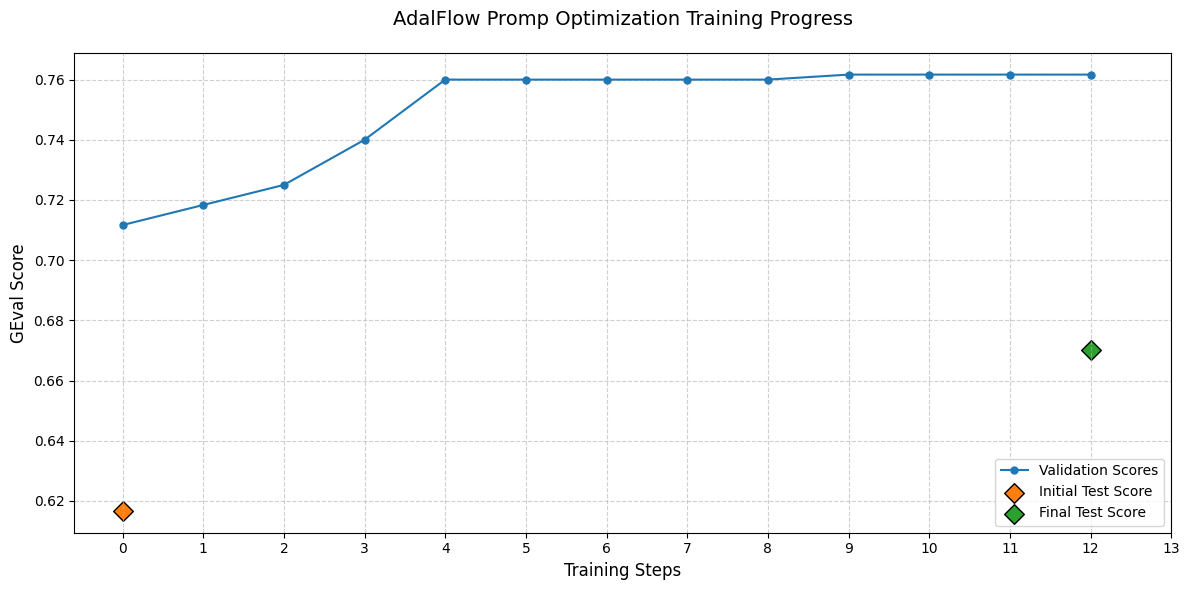

In [12]:
file = ('C:\\Users\\wuhan\\AppData\\Roaming\\adalflow\\ckpt\\HotPotQAAdal\\constrained_max_steps_12_db413_run_1.json')
plot_training_single(file)